## TP3

#### Alumno: Emmanuel Cardozo

▪ Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en
Material_TPs / images a partir del template Material_TPs / template

1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi png con el mismo témplate del item 2
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza de la detección

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

Cargamos las imágenes primeramente:

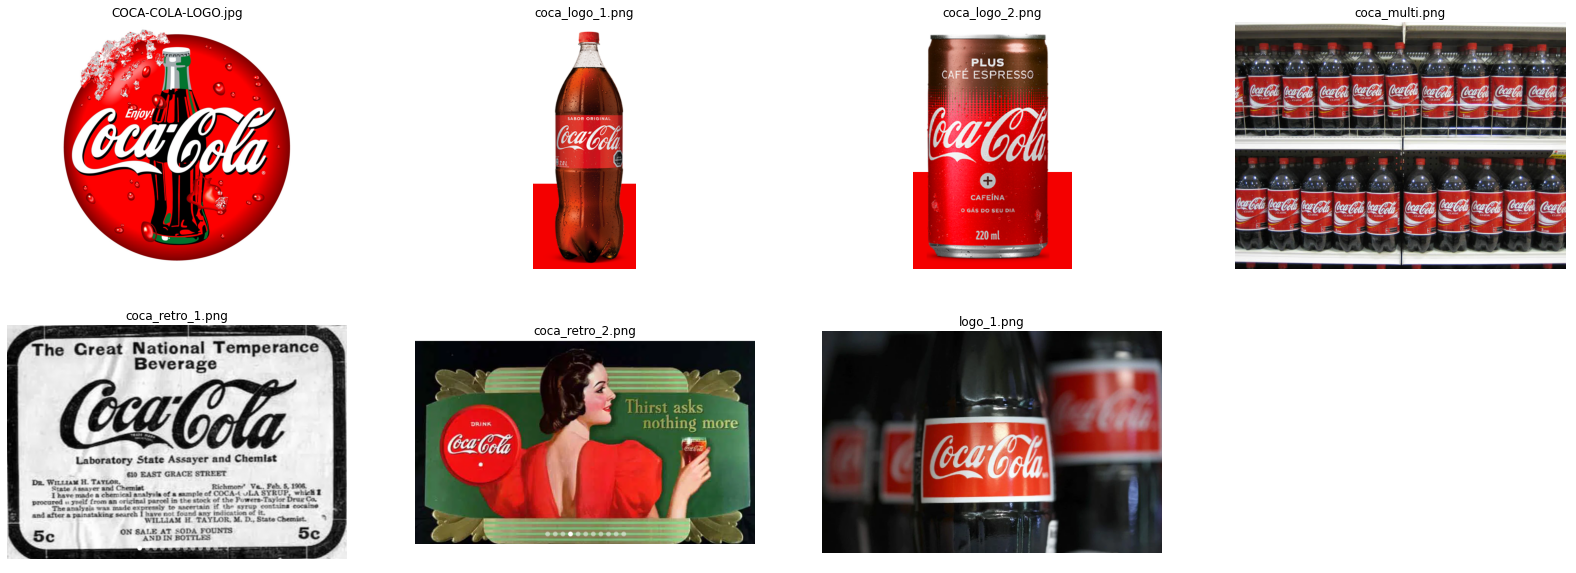

In [2]:
def load_image(path, filename, grayscale=False):
    flags = {"flags": cv.IMREAD_GRAYSCALE} if grayscale else {}
    img = cv.imread(os.path.join(path, filename), **flags)
    if grayscale:
        return img
    return cv.cvtColor(img, cv.COLOR_BGR2RGB)


base_path = R"C:\Users\Emmanuel\Desktop\Esp. en IA\2_VPC1\TP3\assets"
images_path = os.path.join(base_path, "images")

filenames = os.listdir(images_path)
images = [load_image(images_path, filename) for filename in filenames]

_, axes = plt.subplots(2, 4, figsize=(28, 10))
for i in range(2):
    for j in range(4):
        idx = i * 4 + j
        if idx < 7:
            axes[i][j].imshow(images[idx])
            axes[i][j].title.set_text(filenames[idx])
        axes[i][j].axis("off")

Cargamos el template:

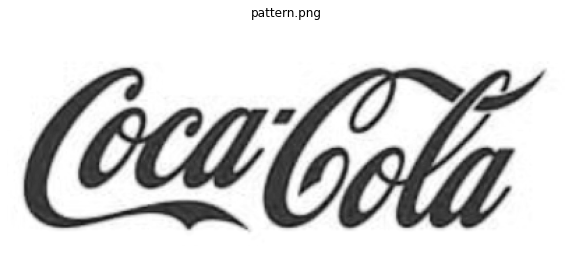

In [3]:
template_path = os.path.join(base_path, "template")

template = load_image(template_path, "pattern.png", grayscale=True)

plt.figure(figsize=(10, 10))
plt.imshow(template, cmap="gray")
plt.axis("off")
plt.title("pattern.png")
plt.show()

Creamos una función customizada `resize_scale()` para reesacalar el template a cualquier tamaño dado.

In [7]:
def resize_scale(img, min_scale=1, max_scale=20, steps=10):
    resized_scale = []
    if min_scale <= 0 or max_scale <= 0 or min_scale >= max_scale:
        raise Exception("Invalid values")
    if max_scale > 1 and min_scale < 1:
        scale_down = np.linspace(min_scale, 1, steps // 2, endpoint=False)
        scale_up = np.linspace(1, max_scale, steps // 2 + 1 if steps % 2 else steps // 2)
        scales = np.concatenate((scale_down, scale_up))
    else:
        scales = np.linspace(min_scale, max_scale, steps)
    scales
    (h, w) = img.shape
                
    for scale in scales:
        if scale == 1:
            resized_scale.append(img)
        else:
            resized_scale.append(cv.resize(img, (round(w * scale), round(h * scale)), interpolation=cv.INTER_AREA if scale < 1 else cv.INTER_CUBIC,))
    return  resized_scale

Creamos algunos templates con nuevas escalas:

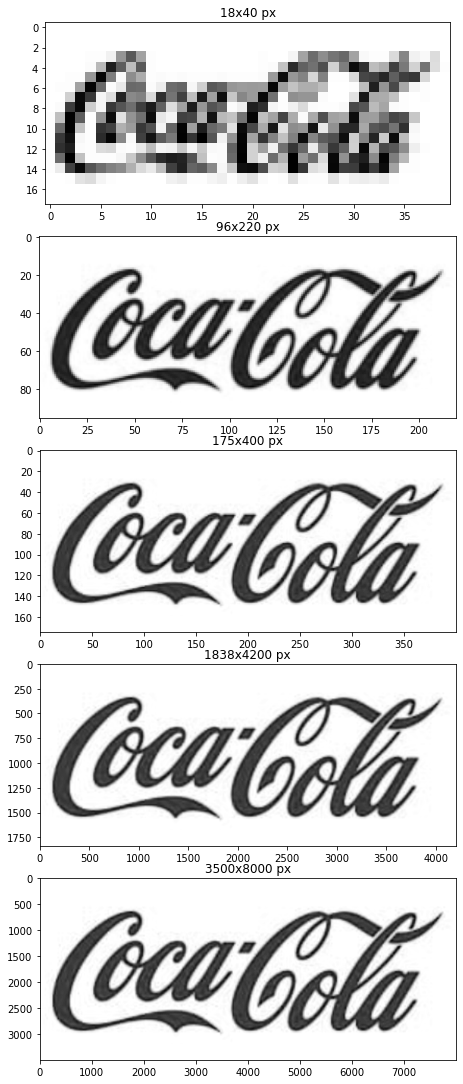

In [8]:
resized_templates = resize_scale(template, 0.1, 20, 5)
_, axes = plt.subplots(len(resized_templates), figsize=(15, 15))
plt.tight_layout()
for i in range(len(resized_templates)):
    img = resized_templates[i]
    axes[i].imshow(img, cmap="gray")
    axes[i].title.set_text(f"{img.shape[0]}x{img.shape[1]} px")

Creamos la función de detección del logo de la marca de la gaseosa: En la función se ingresa el template y se se generan tantas pirámides como lo especifique el parámetro `steps`. Para mejorar el rendimiento del algoritmo se genera otra piramide con los colores del invertidos. Se unen todas los templates distintos en un único vector y se comparan con la imagen de entrada escalada en grises. Se 'matchea' con el mejor score o el que supere el valor de `threshold` en caso de haberse seteado. La función finalmente se devuelve un array con el o los resultados.

In [68]:
def detection(
    img,
    template,
    min_scale=0.1,
    max_scale=10,
    steps=5,
    threshold=None,
    canny_filter = False,
    method=cv.TM_CCOEFF_NORMED,
):
    template_inv = cv.bitwise_not(template)
    template_pyramid = [
        *resize_scale(template, min_scale, max_scale, steps),
        *resize_scale(template_inv, min_scale, max_scale, steps),
    ]
    
    img_gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    img_cannied = cv.Canny(img_gray, 260, 260, apertureSize = 3)  
    
    if canny_filter == True:
        img_gray = img_cannied
    
    results = []
    for template_scaled in template_pyramid:
        try:
            res = cv.matchTemplate(img_gray, template_scaled, method)
            h, w = template_scaled.shape

            if threshold:
                loc = np.where(res >= threshold)
                relevant_detections = []
                for pt in zip(*loc[::-1]):
                    x, y = pt
                    relevant_detections.append((res[y, x], x, y, w, h))
                results.append(relevant_detections)
            else:
                _, max_val, min_loc, max_loc = cv.minMaxLoc(res)
                x, y = (
                    min_loc
                    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]
                    else max_loc
                )
                results.append([(max_val, x, y, w, h)])
        except:
            results.append([(0, 0, 0, 0, 0)])

    return max(results, key=lambda resu: sum(item[0] for item in resu))

Para dibujar los rectángulos de detección del logo en los resutados que brinda el score de matching con el template original, creamos la función de matching. 

In [69]:
green_box = (0, 255, 0)

def detection_plot(
    img,
    template,
    min_scale=1,
    max_scale=10,
    steps=20,
    threshold=None,
    canny_filter = False,
    method=cv.TM_CCOEFF_NORMED,
    title="",
):
    results = detection(img, template, min_scale, max_scale, steps, threshold, canny_filter, method)
    img_rgb = img.copy()

    if len(results) == 1:
        print(f"Score: {results[0][0]:.4f}")
    else:
        print(f"Scores: {[res[0] for res in results]}")

    for score, x, y, w, h in results:
        cv.rectangle(img_rgb, (x, y), (x + w, y + h), green_box, 3)
        cv.putText(
            img_rgb,
            f"{score:.4f}",
            (x, y - 10),
            cv.FONT_HERSHEY_SIMPLEX,
            0.9,
            green_box,
            2,
        )
    plt.figure(figsize=(8, 8))
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.title(title)
    plt.show()

Detectamos los logos en las imágenes:


Score: 0.5662


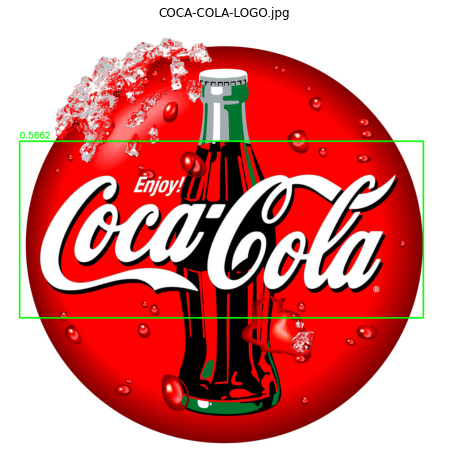

In [70]:
detection_plot(
    images[0],
    template,
    min_scale=1,
    max_scale=5,
    steps=10,
    title=filenames[0],
)

Score: 0.3226


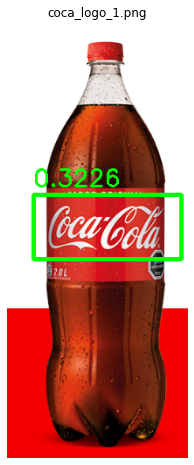

In [71]:
detection_plot(
    images[1],
    template,
    min_scale=0.4,
    max_scale=0.6,
    steps=10,
    title=filenames[1],
)

Score: 1112046336.0000


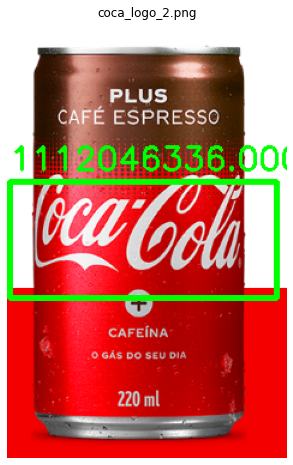

In [72]:
detection_plot(
    images[2],
    template,
    min_scale=0.5,
    max_scale=1,
    steps=10,
    title=filenames[2],
    canny_filter = True,
    method=cv.TM_SQDIFF
)

Scores: [0.54940677, 0.5358846, 0.5287621, 0.5091289, 0.51091576, 0.5816743, 0.50735134, 0.5054295, 0.55600226, 0.5130698, 0.5338764, 0.5716462, 0.5786711, 0.54763687, 0.55983824, 0.5287856, 0.5018116, 0.5402104, 0.56255853, 0.5083368, 0.56997544, 0.5331121, 0.503415, 0.53949463, 0.5488225, 0.5149256, 0.546462, 0.5663855, 0.55693215, 0.5119241, 0.5510876, 0.55074286, 0.57067406, 0.5507376, 0.5460277, 0.5300324, 0.50576234, 0.5754317, 0.51381373, 0.52320915, 0.5558712, 0.54313105, 0.51243246, 0.5480101, 0.55393445, 0.55596787, 0.5346632]


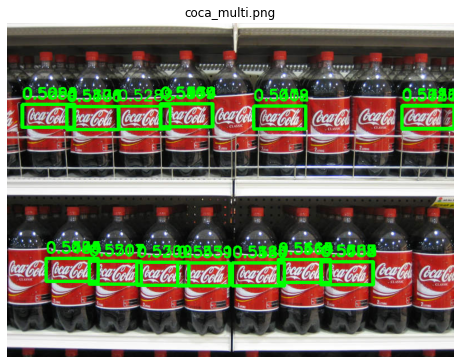

In [73]:
detection_plot(
    images[3],
    template,
    min_scale=0.1,
    max_scale=0.5,
    steps=10,
    threshold=0.5,
    title=filenames[3],
)

Score: 0.6864


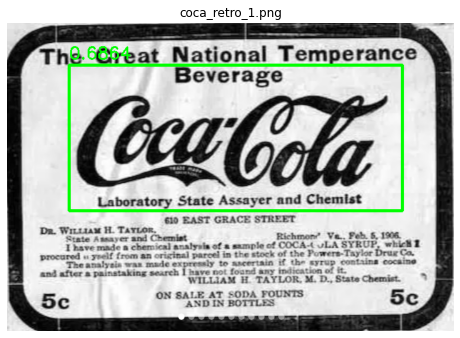

In [74]:
detection_plot(
    images[4],
    template,
    min_scale=1,
    max_scale=2,
    steps=10,
    title=filenames[4],
)

Score: 0.6295


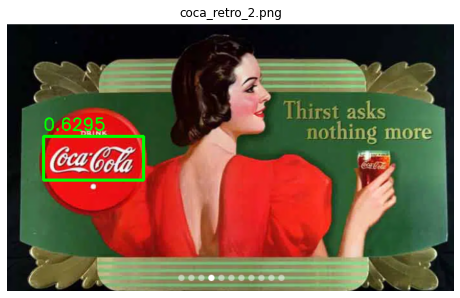

In [75]:
detection_plot(
    images[5],
    template,
    min_scale=0.1,
    max_scale=1,
    steps=10,
    title=filenames[5],
)

Score: 0.4250


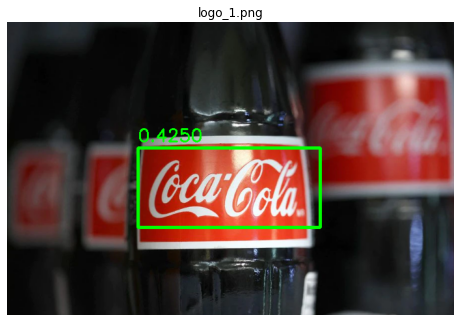

In [76]:
detection_plot(
    images[6],
    template,
    min_scale=0.5,
    max_scale=2,
    steps=10,
    title=filenames[6],
)

### Conclusiones

La función implementada funciona muy bien para la deteccion del logo de la marca de la gaseosa en las imágenes propuestas, aunque requiere de un seteo de los parámetros de matching muy manual para cada imagen a analizar.

En el caso de la imagen 2, tuvo que efectuarse antes a la imagen a analizar un filtrado por Canny para poder efectuar un correcto match, como así también se modificó el método de matching en Open CV (el método TM_CCOEFF_NORMED seteado por default, no pudo nunca matchear el logo correctamente).